# Stacking 6 years of imagery into a GIF

We'll load all the [Landsat-8 (Collection 2, Level 2)](https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2) data that's available from [Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/) over a small region on the coast of [Cape Cod](https://www.google.com/maps/place/Chatham,+MA/@41.7498076,-70.2026227,10.73z/data=!4m13!1m7!3m6!1s0x89fb15440149e94d:0x1f9c0efa001cb20b!2sCape+Cod!3b1!8m2!3d41.6687897!4d-70.2962408!3m4!1s0x89fb142168afbe53:0x714436ec7d485a53!8m2!3d41.6821432!4d-69.9597359), Massachusetts, USA.


Using nothing but standard xarray syntax, we'll mask cloudy pixels with the Landsat QA band and reduce the data down to biannual median composites.

[Animated](https://geogif.readthedocs.io/en/latest/) as a GIF, we can watch the coastline move over the years due to [longshore drift](https://en.wikipedia.org/wiki/Longshore_drift).

Planetary Computer is Microsoft's open Earth data initiative. It's particularly nice to use, since they also maintain a [STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) for searching all the data, as well as a browseable [data catalog](https://planetarycomputer.microsoft.com/catalog). It's free for anyone to use, though you have to [sign your requests](https://planetarycomputer.microsoft.com/docs/concepts/sas/) with the `planetary_computer` package to prevent abuse. If you [sign up](https://planetarycomputer.microsoft.com/account/request), you'll get faster reads.

In [1]:
import coiled
import distributed
import dask
import pystac_client
import planetary_computer as pc
import ipyleaflet
import IPython.display as dsp
import geogif
import stackstac

Using a cluster will make this _much_ faster. Particularly if you're not in Europe, which is where this data is stored.

You can sign up for a Coiled account and run clusters for free at https://cloud.coiled.io/ — no credit card or username required, just sign in with your GitHub or Google account.

In [2]:
cluster = coiled.Cluster(
    name="gjoseph92/stackstac",
    software="stackstac",
    backend_options={"region": "eu-central-1"},
    # ^ Coiled doesn't yet support Azure's West Europe region, so instead we'll run on a nearby AWS data center in Frankfurt
    n_workers=20,
)
client = distributed.Client(cluster)
client

Using existing cluster: 'stackstac'

<Client: 'tls://10.12.13.42:8786' processes=20 threads=80, memory=320.00 GiB>

Interactively pick the area of interest from a map. Just move the map around and re-run all cells to generate the timeseries somewhere else!

In [3]:
m = ipyleaflet.Map(scroll_wheel_zoom=True)
m.center = 41.64933994767867, -69.94438630063088
m.zoom = 12
m.layout.height = "800px"
m

Map(center=[41.64933994767867, -69.94438630063088], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [4]:
bbox = (m.west, m.south, m.east, m.north)

## Search for STAC items

Use [pystac-client](https://github.com/stac-utils/pystac-client) to connect to Microsoft's STAC API endpoint and search for Landsat-8 scenes.

In [5]:
catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

search = catalog.search(
    collections=['landsat-8-c2-l2'],
    bbox=bbox,
)
search.matched()

357

In [6]:
%%time
items = search.items_as_collection()

CPU times: user 719 ms, sys: 45.7 ms, total: 764 ms
Wall time: 15.2 s


Sign all the STAC items with a token from Planetary Computer. Without this, loading the data will fail.

In [7]:
items = pystac_client.ItemCollection([pc.sign_assets(item) for item in items.features])

These are the footprints of all the items we'll use:

In [ ]:
dsp.GeoJSON(items.to_dict())

## Create an xarray with stacksatc

Set `bounds_latlon=bbox` to automatically clip to our area of interest (instead of using the full footprints of the scenes).

In [9]:
%%time
stack = stackstac.stack(items, bounds_latlon=bbox)
stack

CPU times: user 362 ms, sys: 11.4 ms, total: 374 ms
Wall time: 372 ms


<xarray.DataArray 'stackstac-9678efaf932b81b94aa1dceb9a89fb92' (time: 357, band: 19, y: 774, x: 1261)>
dask.array<fetch_raster_window, shape=(357, 19, 774, 1261), dtype=float64, chunksize=(1, 1, 774, 1024), chunktype=numpy.ndarray>
Coordinates: (12/26)
  * time                         (time) datetime64[ns] 2013-03-22T15:19:00.54...
    id                           (time) <U40 'LC08_L2SP_011031_20130322_20200...
  * band                         (band) <U9 'QA_PIXEL' 'QA_RADSAT' ... 'ST_QA'
  * x                            (x) float64 4.024e+05 4.025e+05 ... 4.402e+05
  * y                            (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    landsat:collection_category  (time) object None None None ... 'T2' 'T1' 'T1'
    ...                           ...
    view:sun_azimuth             (time) float64 149.6 148.3 ... 153.9 149.3
    gsd                          (band) object None None None ... 30.0 30.0 30.0
    title                        (band) <U46 'Pixel Quality Assessment Band' ...
    common_name                  (band) object None None 'coastal' ... None None
    center_wavelength            (band) object None None 0.44 ... None None None
    full_width_half_max          (band) object None None 0.02 ... None None None
Attributes:
    spec:           RasterSpec(epsg=32619, bounds=(402426.3431542461, 4599672...
    crs:            epsg:32619
    transform:      | 30.00, 0.00, 402426.34|\n| 0.00,-30.00, 4622889.48|\n| ...
    resolution_xy:  (29.996000533262233, 29.995973694806068)

And that's it for stackstac! Everything from here on is just standard xarray operations.

In [10]:
# use common_name for bands
stack = stack.assign_coords(band=stack.common_name.fillna(stack.band).rename("band"))
stack.band

<xarray.DataArray 'band' (band: 19)>
array(['QA_PIXEL', 'QA_RADSAT', 'coastal', 'blue', 'green', 'red', 'nir08',
       'swir16', 'swir22', 'SR_B8', 'lwir11', 'ST_ATRAN', 'ST_CDIST',
       'ST_DRAD', 'ST_URAD', 'ST_TRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA'],
      dtype=object)
Coordinates: (12/15)
  * band                       (band) object 'QA_PIXEL' 'QA_RADSAT' ... 'ST_QA'
    description                (band) <U91 'Collection 2 Level-1 Pixel Qualit...
    landsat:wrs_type           <U1 '2'
    platform                   <U9 'landsat-8'
    view:off_nadir             int64 0
    landsat:wrs_row            <U3 '031'
    ...                         ...
    instruments                object {'oli', 'tirs'}
    gsd                        (band) object None None None ... 30.0 30.0 30.0
    title                      (band) <U46 'Pixel Quality Assessment Band' .....
    common_name                (band) object None None 'coastal' ... None None
    center_wavelength          (band) object None None 0.44 ... None None None
    full_width_half_max        (band) object None None 0.02 ... None None None

See how much input data there is for just RGB. This is the amount of data we'll end up processing

In [11]:
stack.sel(band=["red", "green", "blue"])

<xarray.DataArray 'stackstac-9678efaf932b81b94aa1dceb9a89fb92' (time: 357, band: 3, y: 774, x: 1261)>
dask.array<getitem, shape=(357, 3, 774, 1261), dtype=float64, chunksize=(1, 1, 774, 1024), chunktype=numpy.ndarray>
Coordinates: (12/26)
  * time                         (time) datetime64[ns] 2013-03-22T15:19:00.54...
    id                           (time) <U40 'LC08_L2SP_011031_20130322_20200...
  * band                         (band) object 'red' 'green' 'blue'
  * x                            (x) float64 4.024e+05 4.025e+05 ... 4.402e+05
  * y                            (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    landsat:collection_category  (time) object None None None ... 'T2' 'T1' 'T1'
    ...                           ...
    view:sun_azimuth             (time) float64 149.6 148.3 ... 153.9 149.3
    gsd                          (band) object None None None
    title                        (band) <U46 'Red Band (B4)' ... 'Blue Band (...
    common_name                  (band) object 'red' 'green' 'blue'
    center_wavelength            (band) object 0.65 0.56 0.48
    full_width_half_max          (band) object 0.04 0.06 0.06
Attributes:
    spec:           RasterSpec(epsg=32619, bounds=(402426.3431542461, 4599672...
    crs:            epsg:32619
    transform:      | 30.00, 0.00, 402426.34|\n| 0.00,-30.00, 4622889.48|\n| ...
    resolution_xy:  (29.996000533262233, 29.995973694806068)

## Mask cloudy pixels using the QA band

Use the bit values of the Landsat-8 QA band to mask out bad pixels. We'll mask pixels labeled as dilated cloud, cirrus, cloud, or cloud shadow. (By "mask", we mean just replacing those pixels with NaNs).

See page 14 on [this PDF](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1328_Landsat8-9-OLI-TIRS-C2-L2-DFCB-v6.pdf) for the data table describing which bit means what.

In [12]:
# Make a bitmask---when we bitwise-and it with the data, it leaves just the 4 bits we care about
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

'0b11110'

In [13]:
qa = stack.sel(band="QA_PIXEL").astype("uint16")
bad = qa & bitmask  # just look at those 4 bits

good = stack.where(bad == 0)  # mask pixels where any one of those bits are set

(array([  6., 171., 168.,   8.,   0.,   0.,   2.,   0.,   0.,   1.]),
 array([ 0. ,  3.9,  7.8, 11.7, 15.6, 19.5, 23.4, 27.3, 31.2, 35.1, 39. ]),
 <BarContainer object of 10 artists>)

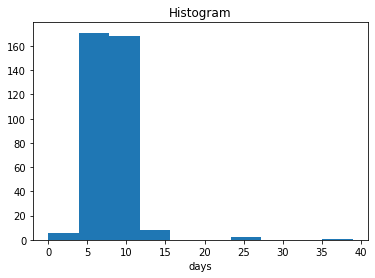

In [14]:
# What's the typical interval between scenes?
good.time.diff("time").dt.days.plot.hist()

## Make biannual median composites

The Landsat-8 scenes appear to typically be 5-10 days apart. Let's composite that down to a 6-month interval.

Since the cloudy pixels we masked with NaNs will be ignored in the `median`, this should give us a decent cloud-free-ish image for each.

In [15]:
# Make biannual median composites (`2Q` means 2 quarters)
composites = good.resample(time="2Q").median("time")
composites

<xarray.DataArray 'stackstac-9678efaf932b81b94aa1dceb9a89fb92' (time: 17, band: 19, y: 774, x: 1261)>
dask.array<stack, shape=(17, 19, 774, 1261), dtype=float64, chunksize=(1, 1, 774, 512), chunktype=numpy.ndarray>
Coordinates:
  * time                       (time) datetime64[ns] 2013-03-31 ... 2021-03-31
  * band                       (band) object 'QA_PIXEL' 'QA_RADSAT' ... 'ST_QA'
  * x                          (x) float64 4.024e+05 4.025e+05 ... 4.402e+05
  * y                          (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    landsat:wrs_type           <U1 '2'
    platform                   <U9 'landsat-8'
    view:off_nadir             int64 0
    landsat:wrs_row            <U3 '031'
    landsat:collection_number  <U2 '02'
    landsat:processing_level   <U4 'L2SP'
    proj:epsg                  int64 32619
    instruments                object {'oli', 'tirs'}

Pick the red-green-blue bands to make a true-color image.

In [16]:
rgb = composites.sel(band=["red", "green", "blue"])
rgb

<xarray.DataArray 'stackstac-9678efaf932b81b94aa1dceb9a89fb92' (time: 17, band: 3, y: 774, x: 1261)>
dask.array<getitem, shape=(17, 3, 774, 1261), dtype=float64, chunksize=(1, 1, 774, 512), chunktype=numpy.ndarray>
Coordinates:
  * time                       (time) datetime64[ns] 2013-03-31 ... 2021-03-31
  * band                       (band) object 'red' 'green' 'blue'
  * x                          (x) float64 4.024e+05 4.025e+05 ... 4.402e+05
  * y                          (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    landsat:wrs_type           <U1 '2'
    platform                   <U9 'landsat-8'
    view:off_nadir             int64 0
    landsat:wrs_row            <U3 '031'
    landsat:collection_number  <U2 '02'
    landsat:processing_level   <U4 'L2SP'
    proj:epsg                  int64 32619
    instruments                object {'oli', 'tirs'}

Some final cleanup to make a nicer-looking animation:

* Drop the 2021 dates, since we're not far enough into 2021 yet to have enough scenes for a nice-looking composite.
* Forward-fill any NaN pixels from the previous frame, to make the animation look less jumpy.
* Also skip the first frame, since its NaNs can't be filled from anywhere.

In [17]:
cleaned = rgb.loc[:"2021-01-01"].ffill("time")[1:]

## Render the GIF

Use [GeoGIF](https://geogif.readthedocs.io/en/latest/) to turn the stack into an animation. We'll use [dgif](https://geogif.readthedocs.io/en/latest/api.html#dask-dgif) to render the GIF on the cluster, so there's less data to send back. (GIFs are a lot smaller than NumPy arrays!)

In [18]:
%%time
gif_img = geogif.dgif(cleaned).compute()

CPU times: user 2.54 s, sys: 121 ms, total: 2.66 s
Wall time: 25.2 s


In [19]:
# we turned ~7GiB of data into a 4MB GIF!
dask.utils.format_bytes(len(gif_img.data))

'3.99 MiB'

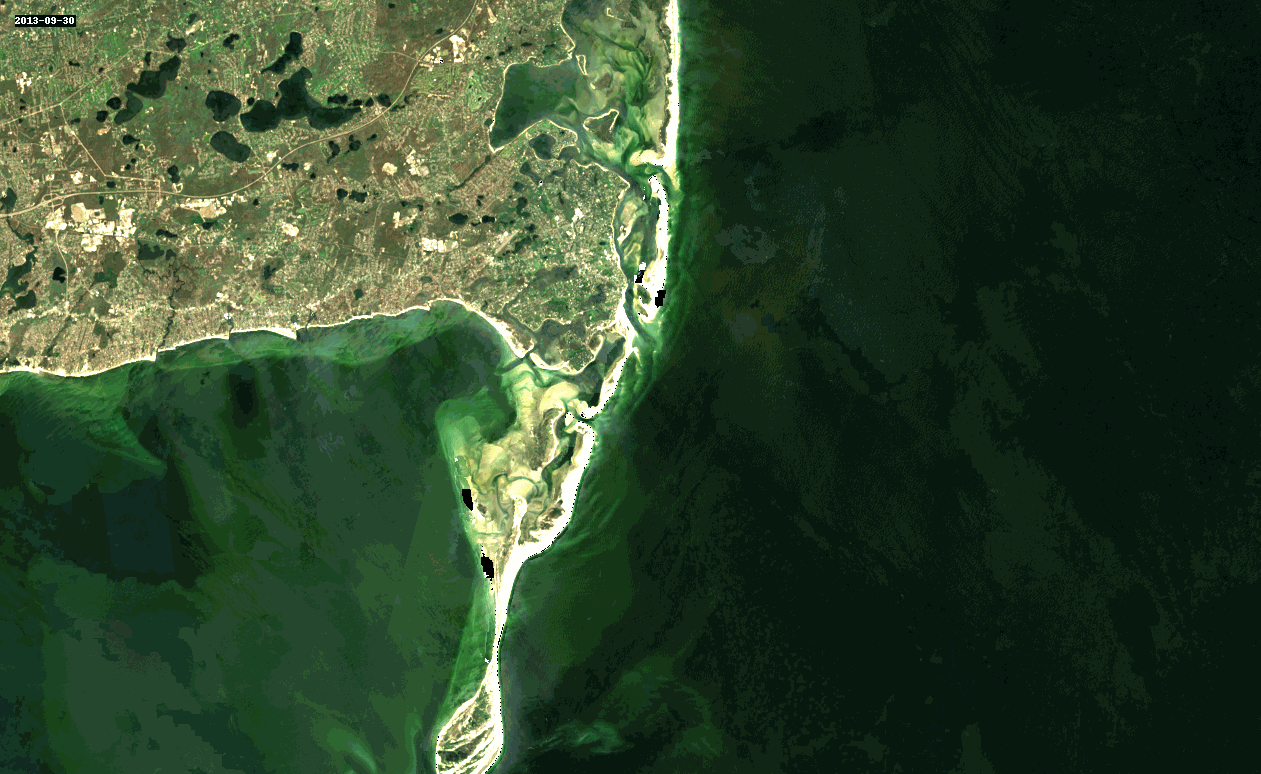

In [20]:
gif_img